In [1]:
from thesispy.elastix_wrapper.runner import run
from thesispy.elastix_wrapper.parameters import Parameters, Collection
from thesispy.definitions import *

from pathlib import Path

2023-03-23 23:49:01,508 - Runner - INFO - Running elastix in: ../output/1679611741_learn_1_adaptivestochasticgradientdescent_507503



elastix is started at Thu Mar 23 23:49:01 2023.

which elastix:   /home/joasiee/Documents/projects/elastix/build/Release/bin/elastix
  elastix version: 5.1.0
  Git revision SHA: 5a2f18be46d9ee0029ad5c3b7690fde1020dc9f4
  Git revision date: Thu Mar 23 21:42:01 2023 +0100
  Build date: Mar 23 2023 21:42:18
  Compiler: GCC version 12.2.1 20230201
  Memory address size: 64-bit
  CMake version: 3.26.0
  ITK version: 5.3.0

Command-line arguments: 
  -p ../output/1679611741_learn_1_adaptivestochasticgradientdescent_507503/params_1.txt -f /home/joasiee/Documents/projects/instances/learn/scans/01_Fixed.nii.gz -m /home/joasiee/Documents/projects/instances/learn/scans/01_Moving.nii.gz -out ../output/1679611741_learn_1_adaptivestochasticgradientdescent_507503/out -threads 6 -fMask /home/joasiee/Documents/projects/instances/learn/masks/01_Fixed.nii.gz

elastix runs at: archlinux
  Linux 6.1.20-1-lts (x64), #1 SMP PREEMPT_DYNAMIC Fri, 17 Mar 2023 13:31:00 +0000
  with 31842 MB memory, and 10 cores

2023-03-23 23:49:05,343 - Validation - INFO - Calculating validation metrics for LEARN:
2023-03-23 23:49:05,343 - Validation - INFO - TRE: 4.64949192099158
2023-03-23 23:49:05,343 - Validation - INFO - Bending Energy: 0.79
2023-03-23 23:49:05,454 - Validation - INFO - Jacobian min,max: 0.37225587557729883, 2.0255203027882827
computing bending energy: 100%|██████████| 31225/31225.0 [00:02<00:00, 11684.05it/s]
2023-03-23 23:49:08,213 - Validation - INFO - SDLogJ: 0.1443
2023-03-23 23:49:08,214 - Validation - INFO - Dice Similarity: 0.9392
2023-03-23 23:49:08,214 - Validation - INFO - Bending Energy (crude): 1481.3903
2023-03-23 23:49:17,364 - Validation - INFO - Validation metrics calculated in 12.02s
2023-03-23 23:49:17,364 - Runner - INFO - Run ended. It took 15.8564 seconds
libpng warning: iCCP: too many profiles


/home/joasiee/.local/bin/vv


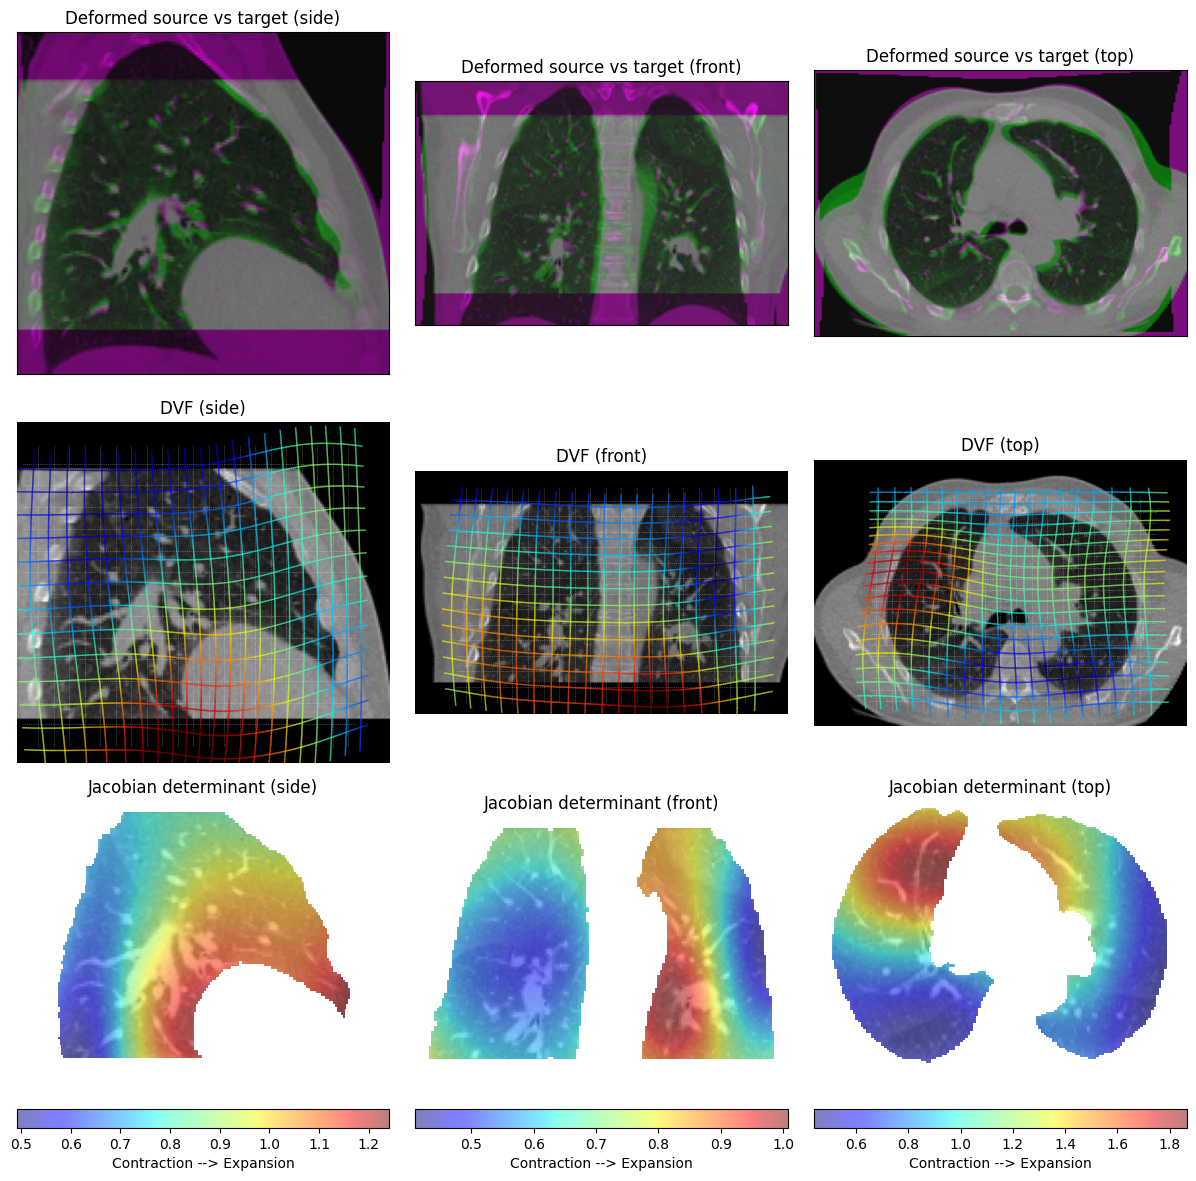

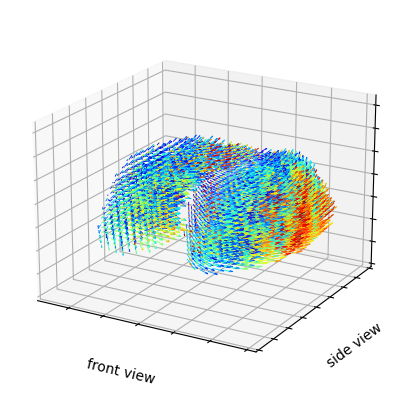

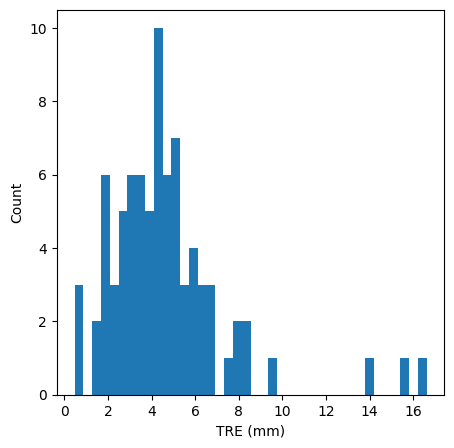

In [11]:
params = (
    Parameters.from_base(use_mask=True, metric="AdvancedNormalizedCorrelation")
    .asgd()
    .multi_resolution(1, r_sched=[5])
    .stopping_criteria(1000)
    .instance(Collection.LEARN, 1)
)
result = run(params, Path("../output/" + str(params)), suppress_stdout=False, visualize=True, validate=True)